**Workflow**:
1. Extract contours and markers from xml files.
2. Reconstruct brains as a set of 3D arrays, one for each structure, based on contours.
3. Define a fixed brain. Align other brains to it. (Omitted.)
4. Load fixed brain and other brains that have been aligned to the fixed brain.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
# from utilities2015 import *
# from metadata import *
# from data_manager import *
from annotation_utilities import *
# from registration_utilities import *
# from conversion import *
from vis3d_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Local Macbook Pro


In [2]:
stacks_to_colors = {'RV4_67hrs': (1,0,0), 'RV14_65hrs': (0,1,0), 'RV19_61hrs': (0,0,1), 'RV13_64hrs': (1,1,0)}

# Reconstruct one brain

In [6]:
stack_fixed = 'RV4_67hrs'

In [ ]:
import xml.etree.ElementTree as ET

def get_stacy_contours(stack):
    """
    Returns:
        (dict {str: list of (n,3)-arrays}, dict {str: (n,3)-array}): contours, markers
    """

#     xmlfile = '/shared/stacy_data/%s.xml' % stack
    xmlfile = '/home/yuncong/stacy_data/%s.xml' % stack
    download_from_s3(xmlfile)

    # create element tree object
    tree = ET.parse(xmlfile)

    # get root element
    root = tree.getroot()

    prefix = '{http://www.mbfbioscience.com/2007/neurolucida}'

    # neurolucida_name_map = \
    # {"Contour Name 1": 'RMC',
    # "Contour Name 2": '3N',
    # "Contour Name 3": 'fr',
    # 'Brain': 'outerContour',
    #  'SNR': 'SNR'}

    neurolucida_name_map = \
    {"IO": 'IO_L',
    "LRT": 'LRt_L',
    # "BRAINSTEM": 'brainstem',
    '5 MOTOR': '5N_L',
     '7n': '7n_L',
    'AMB MOTOR': 'Amb_L',
    'FACIAL MOTOR': '7N_L',
     'SpVC': 'Sp5C_L',
     'SpVO': 'Sp5O_L',
     'Sp5I': 'Sp5I_L',
     'Pr5': 'Pr5_L',
     'Sol': 'Sol_L',
     'Li': 'Li_L',
    #  'SpVIO': 'unknown',
    'R LrT': 'LRt_R',
    'R FN':  '7N_R',
    'R_7n': '7n_R',
    'R 5N':  '5N_R',
    'R SpVC': 'Sp5C_R',
    'R Sp5I': 'Sp5I_R',
    'R SpVO': 'Sp5O_R',
    'R Pr5':  'Pr5_R',
    'R IO':  'IO_R',
     'R-SpVI':  'Sp5I_R',
    'R-SpV':  'Sp5_R',
    'R-SpVO':  'Sp5O_R',
     'R-PrV':  'Pr5_R',
     'R-Amb':  'Amb_R',
    #  'R SpVIO':  'unknown',
     'SpVC_R':  'Sp5C_R',
     'R 5M':  '5N_R',
    #  'User Line 5':  'unknown',
    #  'NewContour': 'unknown',
    #   'User Line 2':  'unknown',
    }

    contours = defaultdict(list)

    for item in root.findall(prefix+'contour'):
        name = item.attrib['name']
        if name not in neurolucida_name_map:
    #         raise Exception('Name %s in stack %s not recognized' % (name, stack))
            sys.stderr.write('Name %s in stack %s not recognized. Ignored.\n' % (name, stack))
            continue
        name = neurolucida_name_map[name]
        curr_contour = []
    #     try:
    #         resolution = float(item.findall(prefix+'resolution')[0].text)
    #         print resolution
    #     except:
    #         pass
        for p in item.findall(prefix+'point'):
            curr_contour.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        contours[name].append(np.array(curr_contour))

    contours.default_factory = None

    #################

    # structure_subset = ['3N_L', 'RMC_L', 'SNR_L']
    structure_subset = \
    [name for name in contours.keys() if parse_label(name)[0] in all_known_structures]
    print structure_subset

    ####################

    downscale = 32

    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':
        contours_orientationCorrected = {name_u: [cnt*[1,-1,1]
                                         for cnt in cnts3d if len(cnt) > 2] 
                               for name_u, cnts3d in contours.iteritems()}
    else:
        contours_orientationCorrected = {name_u: [cnt*[-1,-1,1]
                                         for cnt in cnts3d] 
                               for name_u, cnts3d in contours.iteritems()}

    contours_atlasResol = {name: [cnt / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                                    for cnt in cnts3d] 
                           for name, cnts3d in contours_orientationCorrected.iteritems()
                                                if name in structure_subset}

    
    #####################
    
    markers = defaultdict(list)
#     markers = {}

    for item in root.findall(prefix+'marker'):
        curr_markers = []
        for p in item.findall(prefix+'point'):
            curr_markers.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        name = '7N_R'
        markers[name].append(np.array(curr_markers))
        
    markers = {name: np.concatenate(mkr_lists) for name, mkr_lists in markers.iteritems()}

    # markers.default_factory = None
    
    #########################
    
    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':

        markers_orientationCorrected = {name_u: mkrs3d*[1,-1,1]
                               for name_u, mkrs3d in markers.iteritems()}

    else:
        markers_orientationCorrected = {name_u: mkrs3d*[-1,-1,1]
                           for name_u, mkrs3d in markers.iteritems()}

    markers_atlasResol = {name: mkrs3d / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                           for name, mkrs3d in markers_orientationCorrected.iteritems()
                         if name in structure_subset}
    
    
    return contours_atlasResol, markers_atlasResol

In [15]:
contours_f_rel2world, markers_f_rel2world = get_stacy_contours(stack_fixed)

Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignore

['LRt_R', 'Sp5I_R', '7N_R', 'Sp5C_L', 'Sp5I_L', '7n_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5C_R', 'Sp5O_R', 'Sp5O_L', 'LRt_L']
['Sp5O_R', 'Sp5I_R', 'Sp5C_L', '7N_R', '5N_R', '5N_L', '7N_L', 'Sp5C_R', '7n_L', 'Amb_R', '7n_R', 'Amb_L', 'LRt_R', 'LRt_L']


Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. I

In [17]:
vol_bbox_dict = {}
for name, cnts3d in contours_f_rel2world.iteritems():
    vol_bbox_dict[name] = interpolate_contours_to_volume(interpolation_direction='z',
                                                    contours_xyz=cnts3d, 
                                                    len_interval=20)

In [24]:
vol_bbox_dict['7n_L'][1]

(1235, 1335, 511, 665, 17, 180)

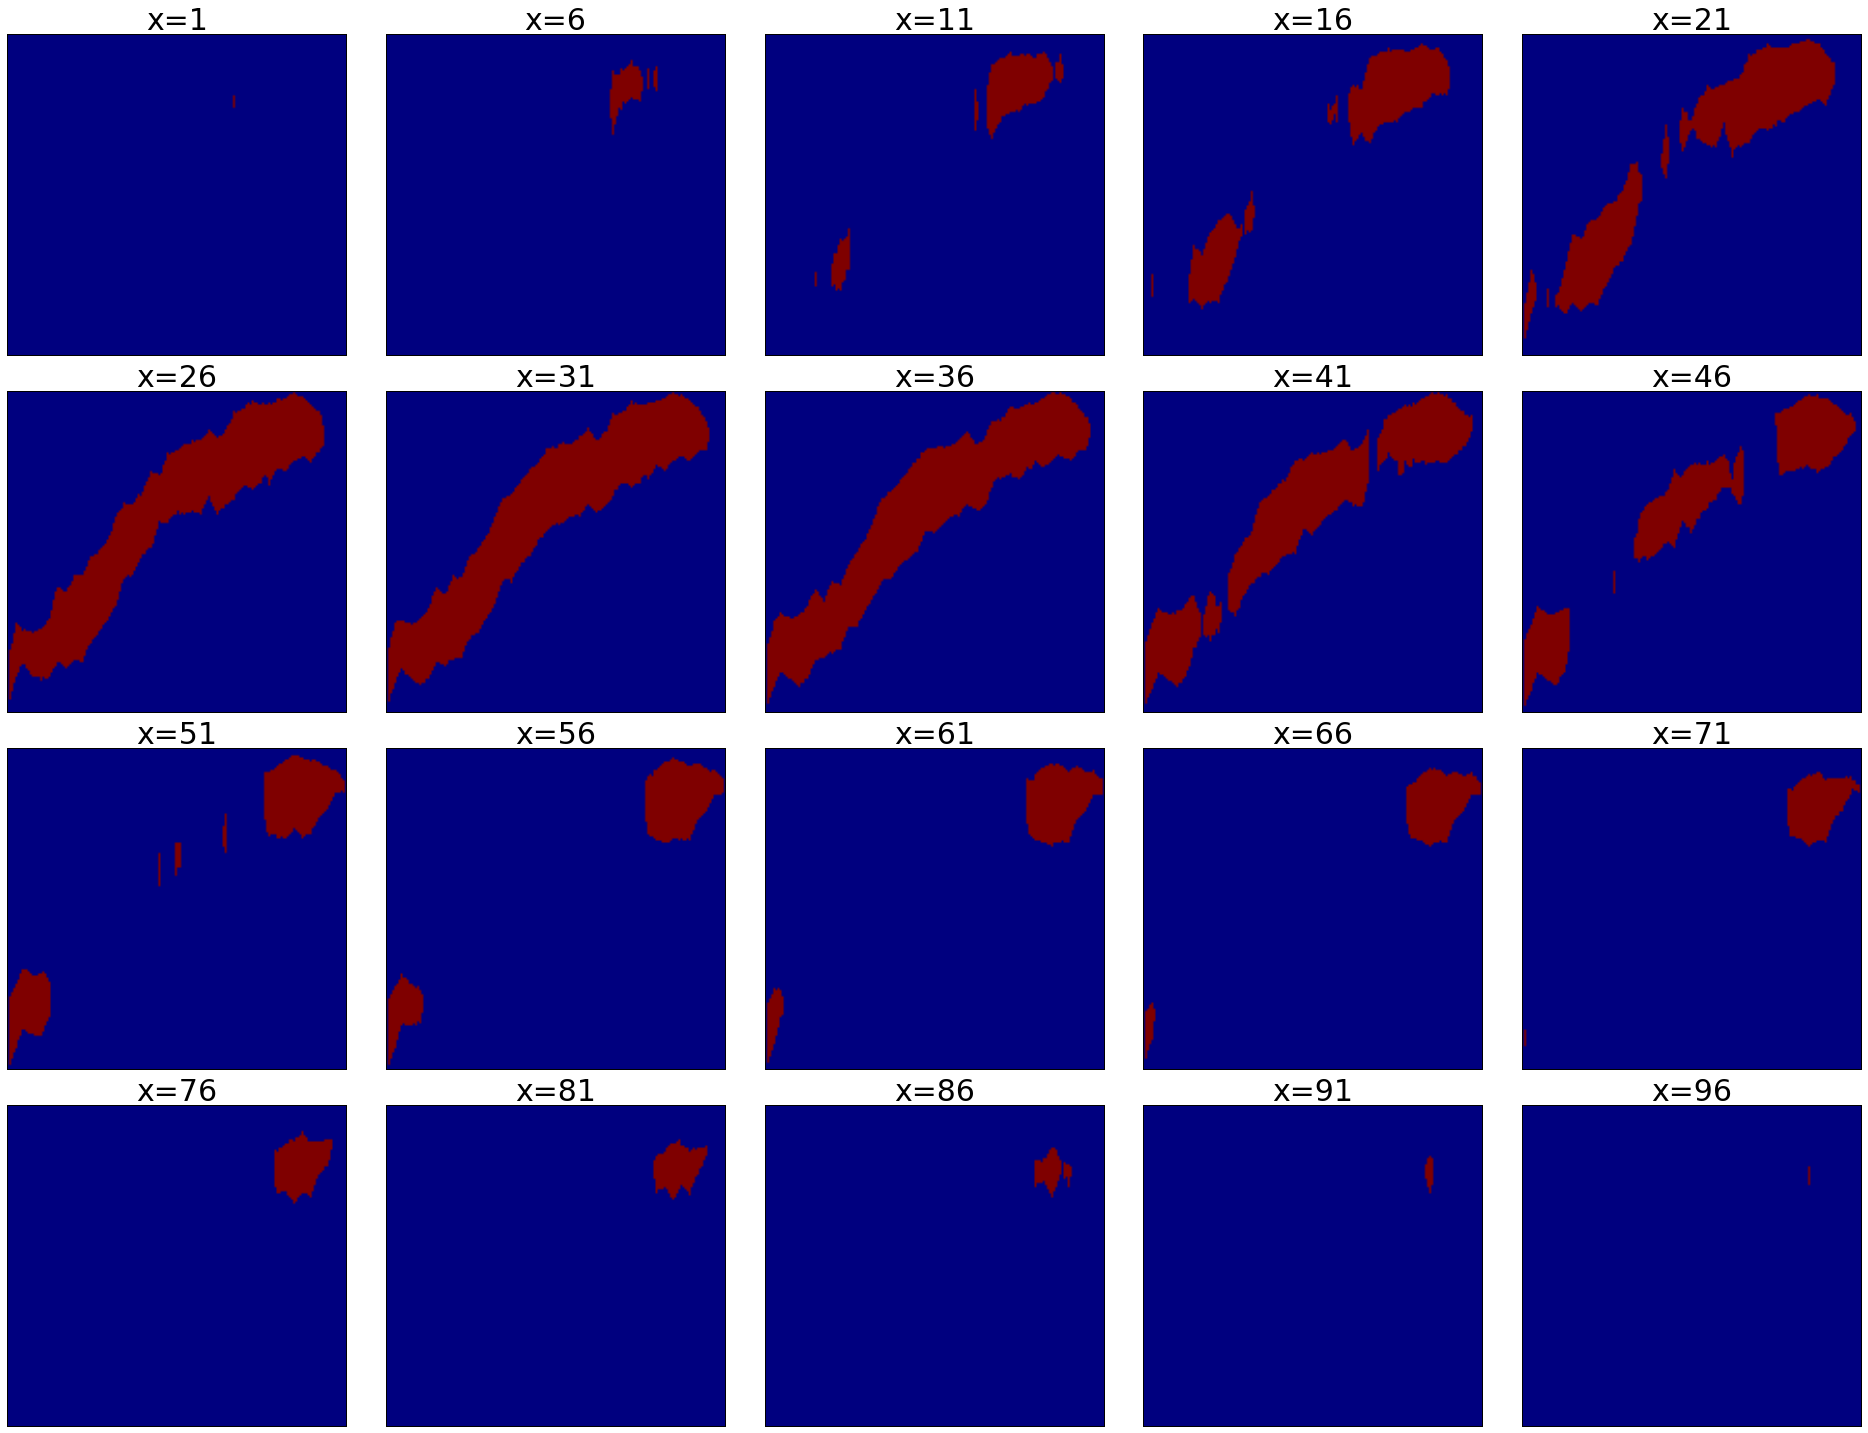

In [23]:
display_volume_sections(vol_bbox_dict['7n_L'][0], direction='x')

In [38]:
polydata_actor_list = []
for name_s in ['7n_R', '7n_L']:
    polydata = volume_to_polydata(vol_bbox_dict[name_s][0], num_simplify_iter=3, smooth=True)
    xmin, _, ymin, _, zmin, _ = vol_bbox_dict[name_s][1]
    polydata_actor = actor_mesh(polydata, origin=(xmin,ymin,zmin), wireframe=True, )
    polydata_actor_list.append(polydata_actor)

marching cube: 0.41 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 47217: 0.56 seconds
simplify 1 @ 9443: 0.49 seconds
simplify 2 @ 1888: 0.10 seconds
marching cube: 0.34 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 38311: 0.42 seconds
simplify 1 @ 7663: 0.33 seconds
simplify 2 @ 1534: 0.08 seconds


In [40]:
launch_vtk(polydata_actor_list + [actor_sphere(position=(0,0,0), radius=10)])

# Align two brains that have been reconstructed (omitted)

# Visualize multiple co-registered brains.

Load fixed brain and another brain that has been transformed into alignment.

In [3]:
VOLUME_ROOTDIR = '/media/yuncong/YuncongPublic/CSHL_volumes' # Change this to match your file organization.

In [4]:
def volume_type_to_str(t):
    if t == 'annotationAsScore':
        return 'annotationAsScoreVolume'
    else:
        raise Exception('Volume type %s is not recognized.' % t)
        
def get_original_volume_basename(stack, structure=None, volume_type='score', **kwargs):

    downscale = 32
    
    components = []
    if downscale is not None:
        components.append('down%(downscale)d' % {'downscale':downscale})
    tmp_str = '_'.join(components)

    basename = '%(stack)s_%(tmp_str)s_%(volstr)s' % \
        {'stack':stack, 'tmp_str':tmp_str, 'volstr':volume_type_to_str(volume_type)}
    if structure is not None:
        basename += '_' + structure
    return basename

def get_warped_volume_basename(stack_m,
                               stack_f=None,
                               warp_setting=None,
                               structure_m=None,
                               structure_f=None,
                               vol_type_m='score',
                               vol_type_f='score',
                               **kwargs):

    basename_m = get_original_volume_basename(stack=stack_m, volume_type=vol_type_m, structure=structure_m)

    if stack_f is None:
        assert warp_setting is None
        vol_name = basename_m
    else:
        basename_f = get_original_volume_basename(stack=stack_f, volume_type=vol_type_f, structure=structure_f)
        vol_name = basename_m + '_warp%(warp)d_' % {'warp':warp_setting} + basename_f

    return vol_name

def load_original_volume(stack, structure, volume_type=None):
    basename = get_original_volume_basename(stack=stack, volume_type=volume_type)
    vol_fp = os.path.join(VOLUME_ROOTDIR, '%(stack)s',
                          '%(basename)s',
                          'score_volumes',
                         '%(basename)s_%(struct)s.bp') % \
    {'stack':stack, 'basename':basename, 'struct':structure}
    
    download_from_s3(vol_fp)
    volume = bp.unpack_ndarray_file(vol_fp).astype(np.float32)
    return volume

def load_original_volume_bbox(stack, structure, volume_type=None):
    basename = get_original_volume_basename(stack=stack, volume_type=volume_type)
    bbox_fp = os.path.join(VOLUME_ROOTDIR, '%(stack)s',
                          '%(basename)s',
                          'score_volumes',
                         '%(basename)s_%(struct)s_bbox.txt') % \
    {'stack':stack, 'basename':basename, 'struct':structure}
    
    download_from_s3(bbox_fp)

    
    volume_bbox = np.loadtxt(bbox_fp).astype(np.int)
    return volume_bbox    
    
def load_original_volume_all_known_structures_v2(stack,
                                                structures=None,
                                                sided=True,
                                                include_surround=False,
                                                 return_label_mappings=False,
                                                 name_or_index_as_key='name',
                                                 common_shape=True):
    """
    Load original (un-transformed) volumes for all structures and optionally normalize them into a common shape.

    Args:
        common_shape (bool): If true, volumes are normalized to the same shape.

    Returns:
        If `common_shape` is True:
            if return_label_mappings is True, returns (volumes, common_bbox, structure_to_label, label_to_structure), volumes is dict.
            else, returns (volumes, common_bbox).
        If `common_shape` is False:
            if return_label_mappings is True, returns (dict of volume_bbox_tuples, structure_to_label, label_to_structure).
            else, returns volume_bbox_tuples.
    """

    if structures is None:
        if sided:
            if include_surround:
                structures = all_known_structures_sided_with_surround
            else:
                structures = all_known_structures_sided
        else:
            structures = all_known_structures

    loaded = False
    sys.stderr.write('Prior structure/index map not found. Generating a new one.\n')

    volumes = {}
    if not loaded:
        structure_to_label = {}
        label_to_structure = {}
        index = 1
    for structure in structures:
        try:

            if loaded:
                index = structure_to_label[structure]

            v = load_original_volume(stack=stack, structure=structure, volume_type='annotationAsScore')
            b = load_original_volume_bbox(stack=stack, structure=structure, volume_type='annotationAsScore')

            if name_or_index_as_key == 'name':
                volumes[structure] = (v,b)
            else:
                volumes[index] = (v,b)

            if not loaded:
                structure_to_label[structure] = index
                label_to_structure[index] = structure
                index += 1

        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Score volume for %s does not exist.\n' % structure)

    if common_shape:
        volumes_normalized, common_bbox = convert_vol_bbox_dict_to_overall_vol(vol_bbox_dict=volumes)

        if return_label_mappings:
            return volumes_normalized, common_bbox, structure_to_label, label_to_structure
        else:
            return volumes_normalized, common_bbox
    else:
        if return_label_mappings:
            return volumes, structure_to_label, label_to_structure
        else:
            return volumes
        
def load_transformed_volume(stack_m, stack_f,
                            warp_setting,
                            structure_f=None,
                            structure_m=None,
                            vol_type_m=None,
                            vol_type_f=None,
                            structure=None):
    basename = get_warped_volume_basename(**locals())
    if structure is not None:
        fn = basename + '_%s' % structure
    else:
        fn = basename
    fp = os.path.join(VOLUME_ROOTDIR, stack_m, basename, 'score_volumes', fn + '.bp')
    download_from_s3(fp)
    return bp.unpack_ndarray_file(fp)

def load_transformed_volume_bbox(stack_m, stack_f,
                                    warp_setting,
                                    structure_m=None,
                                    structure_f=None,
                                    vol_type_m='annotationAsScore',
                                    vol_type_f='annotationAsScore',
                                    structure=None,):
    basename = get_warped_volume_basename(**locals())
    if structure is not None:
        fn = basename + '_%s' % structure
    else:
        fn = basename
    fp = os.path.join(VOLUME_ROOTDIR, stack_m, basename, 'score_volumes', fn + '_bbox.txt')
    download_from_s3(fp)
    return np.loadtxt(fp)

def load_transformed_volume_all_known_structures_v2(stack_m,
                                                 stack_f,
                                                warp_setting,
                                                structures=None,
                                                sided=True,
                                                include_surround=False,
                                                 return_label_mappings=False,
                                                 name_or_index_as_key='name',
                                                 common_shape=True
):
    """
    Load transformed volumes for all structures and normalize them into a common shape.

    Args:
        common_shape (bool): If true, volumes are normalized to the same shape.

    Returns:
        If `common_shape` is True:
            if return_label_mappings is True, returns (volumes, common_bbox, structure_to_label, label_to_structure), volumes is dict.
            else, returns (volumes, common_bbox).
        If `common_shape` is False:
            if return_label_mappings is True, returns (dict of volume_bbox_tuples, structure_to_label, label_to_structure).
            else, returns volume_bbox_tuples.
    """

    if structures is None:
        if sided:
            if include_surround:
                structures = all_known_structures_sided_with_surround
            else:
                structures = all_known_structures_sided
        else:
            structures = all_known_structures

    loaded = False
    sys.stderr.write('Prior structure/index map not found. Generating a new one.\n')

    volumes = {}
    if not loaded:
        structure_to_label = {}
        label_to_structure = {}
        index = 1
    for structure in structures:
        try:

            if loaded:
                index = structure_to_label[structure]

            v = load_transformed_volume(stack_m=stack_m, vol_type_m='annotationAsScore',
                                                    stack_f=stack_f, vol_type_f='annotationAsScore',
                                                    warp_setting=warp_setting,
                                                    structure=structure)
            
            b = load_transformed_volume_bbox(stack_m=stack_m, vol_type_m='annotationAsScore',
                                                    stack_f=stack_f, vol_type_f='annotationAsScore',
                                                    warp_setting=warp_setting,
                                                    structure=structure)

            if name_or_index_as_key == 'name':
                volumes[structure] = (v,b)
            else:
                volumes[index] = (v,b)

            if not loaded:
                structure_to_label[structure] = index
                label_to_structure[index] = structure
                index += 1

        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Score volume for %s does not exist.\n' % structure)

    if common_shape:
        volumes_normalized, common_bbox = convert_vol_bbox_dict_to_overall_vol(vol_bbox_dict=volumes)

        if return_label_mappings:
            return volumes_normalized, common_bbox, structure_to_label, label_to_structure
        else:
            return volumes_normalized, common_bbox
    else:
        if return_label_mappings:
            return volumes, structure_to_label, label_to_structure
        else:
            return volumes

In [6]:
stack_fixed = 'RV4_67hrs'

In [7]:
brain_fixed = load_original_volume_all_known_structures_v2(stack=stack_fixed, 
                                                            sided=True, include_surround=False, 
                                                            return_label_mappings=False, 
                                                            name_or_index_as_key='name', common_shape=False)

Prior structure/index map not found. Generating a new one.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'
Score volume for 6N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'
Score volume for 6N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp'
Score volume for Amb_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'
Score volume for Amb_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'
Score volume for LC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'
Score volume for LC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'
Score volume for Pn_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'
Score volume for Pn_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'
Score volume for Tz_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'
Score volume for Tz_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'
Score volume for VLL_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'
Score volume for VLL_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'
Score volume for RMC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'
Score volume for RMC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'
Score volume for SNC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'
Score volume for SNC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'
Score volume for SNR_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'
Score volume for SNR_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'
Score volume for 3N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'
Score volume for 3N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'
Score volume for 4N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'
Score volume for 4N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'
Score volume for PBG_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'
Score volume for PBG_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'
Score volume for 10N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'
Score volume for 10N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'
Score volume for VCA_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'
Score volume for VCA_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'
Score volume for VCP_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'
Score volume for VCP_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'
Score volume for DC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'
Score volume for DC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'
Score volume for AP does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'
Score volume for 12N does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'
Score volume for RtTg does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'
Score volume for SC does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'
Score volume for IC does not exist.


In [8]:
print brain_fixed.keys()

['LRt_R', 'Sp5O_R', 'Sp5C_L', '7N_L', '5N_L', '7N_R', '7n_L', 'Sp5I_L', '5N_R', 'Sp5I_R', 'Sp5C_R', '7n_R', 'Sp5O_L', 'LRt_L']


In [9]:
# Convert volumes to meshes.
fixed_brain_meshes = {name_s: volume_to_polydata(brain_fixed[name_s][0], num_simplify_iter=3, smooth=True) 
                      for name_s in brain_fixed.iterkeys()}

marching cube: 8.08 seconds
mesh_to_polydata: 0.18 seconds
simplify 0 @ 60201: 1.58 seconds
simplify 1 @ 12041: 1.08 seconds
simplify 2 @ 2409: 0.21 seconds
marching cube: 10.65 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 16601: 0.64 seconds
simplify 1 @ 3321: 0.19 seconds
simplify 2 @ 665: 0.04 seconds
marching cube: 11.92 seconds
mesh_to_polydata: 0.15 seconds
simplify 0 @ 96956: 1.36 seconds
simplify 1 @ 19392: 1.19 seconds
simplify 2 @ 3880: 0.24 seconds
marching cube: 8.11 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 37583: 0.45 seconds
simplify 1 @ 7518: 0.37 seconds
simplify 2 @ 1505: 0.07 seconds
marching cube: 8.38 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 23441: 0.25 seconds
simplify 1 @ 4689: 0.22 seconds
simplify 2 @ 939: 0.04 seconds
marching cube: 11.99 seconds
mesh_to_polydata: 0.13 seconds
simplify 0 @ 42139: 0.73 seconds
simplify 1 @ 8429: 0.54 seconds
simplify 2 @ 1687: 0.11 seconds
marching cube: 8.19 seconds
mesh_to_polydata: 0.06 seconds
si

In [15]:
# Create actors - adjust colors and other rendering options.
fixed_brain_actor_list = [actor_mesh(mesh, origin=brain_fixed[name_s][1][[0,2,4]], 
                                     wireframe=True, color=stacks_to_colors[stack_fixed]) 
                          for name_s, mesh in fixed_brain_meshes.iteritems()]

In [11]:
# Load moving brains

moving_brain_actor_list_all_stacks = {}

for stack_moving in ['RV14_65hrs', 'RV13_64hrs', 'RV19_61hrs']:
    
    print stack_moving
    
    brain_movingAlignedToFixed = load_transformed_volume_all_known_structures_v2(stack_m=stack_moving, 
                                                                stack_f=stack_fixed, 
                                                                warp_setting=24,
                                                                sided=True, include_surround=False, 
                                                                return_label_mappings=False, 
                                                                name_or_index_as_key='name', common_shape=False)
    
    print brain_movingAlignedToFixed.keys()
    
    moving_brain_meshes = {name_s: volume_to_polydata(brain_movingAlignedToFixed[name_s][0], num_simplify_iter=3, smooth=True)
                           for name_s in brain_movingAlignedToFixed.iterkeys()}
    
    moving_brain_actor_list = [actor_mesh(mesh, origin=brain_movingAlignedToFixed[name_s][1][[0,2,4]], 
                                      wireframe=True, color=stacks_to_colors[stack_moving]) 
                          for name_s, mesh in moving_brain_meshes.iteritems()]
    
    moving_brain_actor_list_all_stacks[stack_moving] = moving_brain_actor_list

RV14_65hrs
rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp"


Prior structure/index map not found. Generating a new one.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'
Score volume for 6N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'
Score volume for 6N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp'
Score volume for Amb_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'
Score volume for Amb_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'
Score volume for LC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'
Score volume for LC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'
Score volume for Pn_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'
Score volume for Pn_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'
Score volume for Tz_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'
Score volume for Tz_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'
Score volume for VLL_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'
Score volume for VLL_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'
Score volume for RMC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'
Score volume for RMC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'
Score volume for SNC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'
Score volume for SNC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'
Score volume for SNR_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'
Score volume for SNR_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'
Score volume for 3N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'
Score volume for 3N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'
Score volume for 4N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'
Score volume for 4N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp'
Score volume for Sp5I_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'
Score volume for Sp5O_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'
Score volume for PBG_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'
Score volume for PBG_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'
Score volume for 10N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'
Score volume for 10N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'
Score volume for VCA_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'
Score volume for VCA_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'
Score volume for VCP_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'
Score volume for VCP_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'
Score volume for DC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'
Score volume for DC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'
Score volume for AP does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'
Score volume for 12N does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'
Score volume for RtTg does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'
Score volume for SC does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'
Score volume for IC does not exist.
marching cube: 0.15 seconds


['LRt_R', 'Sp5O_R', 'Sp5C_L', '7N_L', '5N_L', '7N_R', '7n_L', '5N_R', 'Sp5I_R', 'Sp5C_R', '7n_R', 'LRt_L']


mesh_to_polydata: 0.06 seconds
simplify 0 @ 49833: 0.54 seconds
simplify 1 @ 9961: 0.51 seconds
simplify 2 @ 1989: 0.10 seconds
marching cube: 0.03 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 10868: 0.15 seconds
simplify 1 @ 2175: 0.08 seconds
simplify 2 @ 436: 0.02 seconds
marching cube: 0.33 seconds
mesh_to_polydata: 0.10 seconds
simplify 0 @ 72166: 0.92 seconds
simplify 1 @ 14420: 0.83 seconds
simplify 2 @ 2880: 0.16 seconds
marching cube: 0.10 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 44609: 0.48 seconds
simplify 1 @ 8920: 0.47 seconds
simplify 2 @ 1786: 0.09 seconds
marching cube: 0.06 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 24663: 0.28 seconds
simplify 1 @ 4927: 0.24 seconds
simplify 2 @ 986: 0.06 seconds
marching cube: 0.13 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 47026: 0.94 seconds
simplify 1 @ 9398: 0.81 seconds
simplify 2 @ 1880: 0.17 seconds
marching cube: 0.93 seconds
mesh_to_polydata: 0.10 seconds
simplify 0 @ 39189: 0.75 seconds
s

RV13_64hrs
rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_5N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_5N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_5N_L.bp"
rm -rf "/media/yuncong/YuncongPub

[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'
Score volume for 6N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'
Score volume for 6N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_7N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_7N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_7N_L.bp"
rm -rf "/media/yuncong/YuncongPublic/CSHL_vo

[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp'
Score volume for Amb_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'
Score volume for Amb_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'
Score volume for LC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'
Score volume for LC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LRt_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LRt_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LRt_L.bp"
rm -rf "/media/yuncong/YuncongPublic/CSHL

[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'
Score volume for Pn_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'
Score volume for Pn_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'
Score volume for Tz_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'
Score volume for Tz_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'
Score volume for VLL_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'
Score volume for VLL_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'
Score volume for RMC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'
Score volume for RMC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'
Score volume for SNC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'
Score volume for SNC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'
Score volume for SNR_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'
Score volume for SNR_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'
Score volume for 3N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'
Score volume for 3N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'
Score volume for 4N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'
Score volume for 4N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp"
rm -rf "/media/yuncong/YuncongPublic/C

[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'
Score volume for Sp5O_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp"
rm -rf "/media/yuncong/YuncongPublic/C

[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'
Score volume for PBG_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'
Score volume for PBG_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'
Score volume for 10N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'
Score volume for 10N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'
Score volume for VCA_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'
Score volume for VCA_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'
Score volume for VCP_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'
Score volume for VCP_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'
Score volume for DC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'
Score volume for DC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'
Score volume for AP does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'
Score volume for 12N does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'
Score volume for RtTg does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'
Score volume for SC does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'
Score volume for IC does not exist.


['LRt_R', 'Sp5O_R', 'Sp5C_L', '7N_L', '5N_L', '7N_R', '7n_L', 'Sp5I_L', '5N_R', 'Sp5I_R', 'Sp5C_R', '7n_R', 'LRt_L']


marching cube: 0.28 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 62327: 1.01 seconds
simplify 1 @ 12463: 1.12 seconds
simplify 2 @ 2494: 0.23 seconds
marching cube: 0.15 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 23510: 0.84 seconds
simplify 1 @ 4702: 0.37 seconds
simplify 2 @ 942: 0.08 seconds
marching cube: 0.19 seconds
mesh_to_polydata: 0.10 seconds
simplify 0 @ 26727: 0.65 seconds
simplify 1 @ 5345: 0.32 seconds
simplify 2 @ 1071: 0.06 seconds
marching cube: 0.18 seconds
mesh_to_polydata: 0.07 seconds
simplify 0 @ 45994: 0.62 seconds
simplify 1 @ 9200: 0.53 seconds
simplify 2 @ 1842: 0.10 seconds
marching cube: 0.13 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 28008: 0.47 seconds
simplify 1 @ 5586: 0.31 seconds
simplify 2 @ 1118: 0.06 seconds
marching cube: 0.21 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 53688: 0.80 seconds
simplify 1 @ 10730: 0.59 seconds
simplify 2 @ 2145: 0.11 seconds
marching cube: 0.68 seconds
mesh_to_polydata: 0.06 seconds
simp

RV19_61hrs
rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp"

[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'
Score volume for 6N_L does not exist.



rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'
Score volume for 6N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp'
Score volume for Amb_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'
Score volume for Amb_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_L.bp'
Score volume for LC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_LC_R.bp'
Score volume for LC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_L.bp'
Score volume for Pn_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Pn_R.bp'
Score volume for Pn_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_L.bp'
Score volume for Tz_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Tz_R.bp'
Score volume for Tz_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_L.bp'
Score volume for VLL_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VLL_R.bp'
Score volume for VLL_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_L.bp'
Score volume for RMC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RMC_R.bp'
Score volume for RMC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_L.bp'
Score volume for SNC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNC_R.bp'
Score volume for SNC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_L.bp'
Score volume for SNR_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SNR_R.bp'
Score volume for SNR_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_L.bp'
Score volume for 3N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_3N_R.bp'
Score volume for 3N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_L.bp'
Score volume for 4N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_4N_R.bp'
Score volume for 4N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5I_L.bp'
Score volume for Sp5I_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_L.bp'
Score volume for Sp5O_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_Sp5O_R.bp'
Score volume for Sp5O_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_L.bp'
Score volume for PBG_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_PBG_R.bp'
Score volume for PBG_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_L.bp'
Score volume for 10N_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_10N_R.bp'
Score volume for 10N_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_L.bp'
Score volume for VCA_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCA_R.bp'
Score volume for VCA_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_L.bp'
Score volume for VCP_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_VCP_R.bp'
Score volume for VCP_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_L.bp'
Score volume for DC_L does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_DC_R.bp'
Score volume for DC_R does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_AP.bp'
Score volume for AP does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_12N.bp'
Score volume for 12N does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_RtTg.bp'
Score volume for RtTg does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_SC.bp'
Score volume for SC does not exist.


rm -rf "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" && mkdir -p "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp" "/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp"


[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_warp24_RV4_67hrs_down32_annotationAsScoreVolume_IC.bp'
Score volume for IC does not exist.


['LRt_R', 'Sp5C_L', '7N_L', '5N_L', '7N_R', '7n_L', '5N_R', 'Sp5I_R', 'Sp5C_R', '7n_R', 'LRt_L']


marching cube: 0.73 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 74056: 0.70 seconds
simplify 1 @ 14785: 0.76 seconds
simplify 2 @ 2979: 0.15 seconds
marching cube: 0.09 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 35401: 0.43 seconds
simplify 1 @ 7044: 0.33 seconds
simplify 2 @ 1402: 0.07 seconds
marching cube: 0.52 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 74358: 0.71 seconds
simplify 1 @ 14836: 0.79 seconds
simplify 2 @ 2983: 0.15 seconds
marching cube: 0.13 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 45502: 0.49 seconds
simplify 1 @ 9039: 0.44 seconds
simplify 2 @ 1791: 0.08 seconds
marching cube: 0.13 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 70351: 0.57 seconds
simplify 1 @ 14064: 0.69 seconds
simplify 2 @ 2860: 0.15 seconds
marching cube: 2.20 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 48608: 0.46 seconds
simplify 1 @ 9687: 0.50 seconds
simplify 2 @ 1932: 0.10 seconds
marching cube: 0.06 seconds
mesh_to_polydata: 0.04 seconds
si

Render all brains in 3D.

In [16]:
launch_vtk([a for actor_list in moving_brain_actor_list_all_stacks.values() for a in actor_list] + \
           fixed_brain_actor_list + \
           [actor_sphere(position=(0,0,0), radius=10)]) # a small ball is added to indicate the coordinate origin.